In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ARIMA
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [92]:
# 设置图片参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (15, 8)  # 图片大小

In [3]:
def date_parser(x):
    return datetime.strptime('201' + x, '%Y-%m')

In [4]:
# 加载数据
data_path = "../data/shampoo-sales.csv"
df = pd.read_csv(data_path, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=date_parser)

## 步骤1：观察时间序列

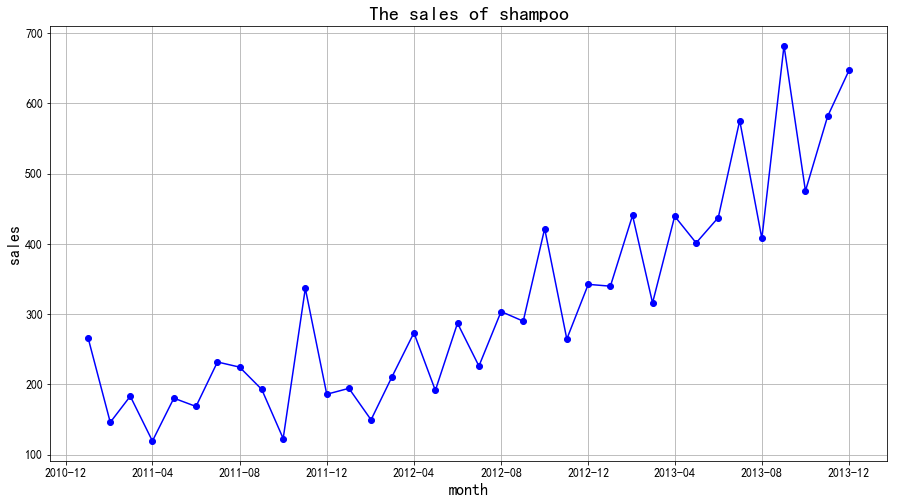

In [27]:
# 绘制时间序列
fig, ax = plt.subplots()
ax.plot(df.index, df.values, 'bo-', )
ax.set_xlabel('month', fontsize=16)
ax.set_ylabel('sales', fontsize=16)
ax.set_title('The sales of shampoo', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/洗发水销量图.png")
plt.show()

## 步骤2：检验时间序列，并确定模型
- 平稳性检验（通过自相关图、偏相关图和单位根检验）
- 纯随机性检验
- 确定模型阶次

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


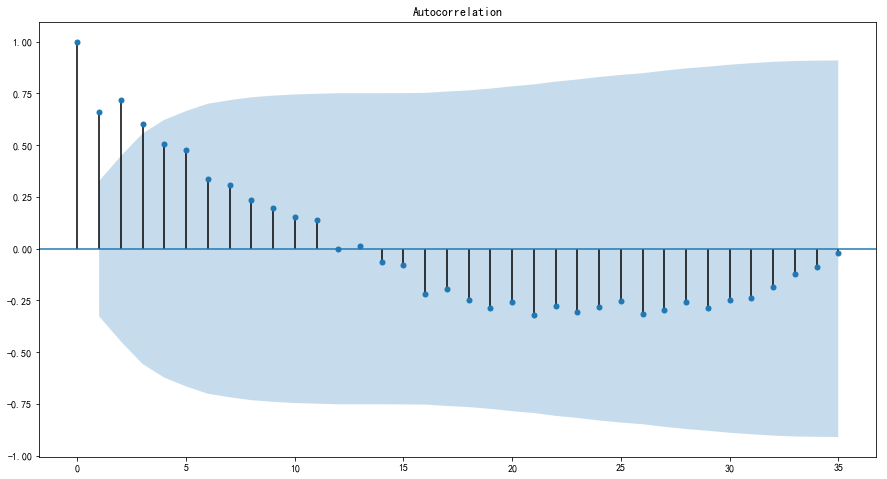

In [28]:
# 绘制自相关图
plot_acf(df).show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


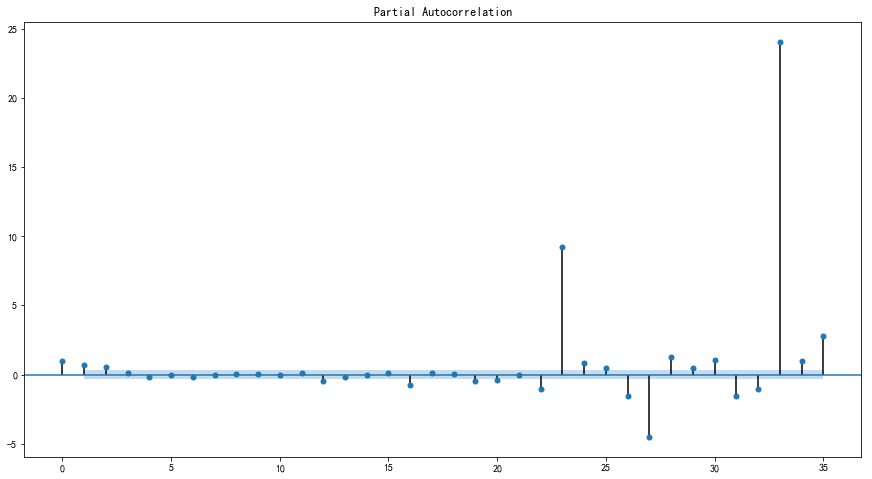

In [29]:
# 偏自相关图
plot_pacf(df).show()

In [35]:
# 单位根检验
adf_result = adfuller(df)

output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("单位根检验结果为：")
print(output)

单位根检验结果为：
                               value
Test Statistic Value         3.06014
p-value                            1
Lags Used                         10
Number of Observations Used       25
Critical Value (1%)         -3.72386
Critical Value (5%)         -2.98649
Critical Value (10%)         -2.6328


**结论：该事件序列是非平稳的。**

因此，需要对模型进行差分，并对差分后的序列进行检验，从而确定差分阶数。

In [39]:
df_diff = df.diff().dropna()

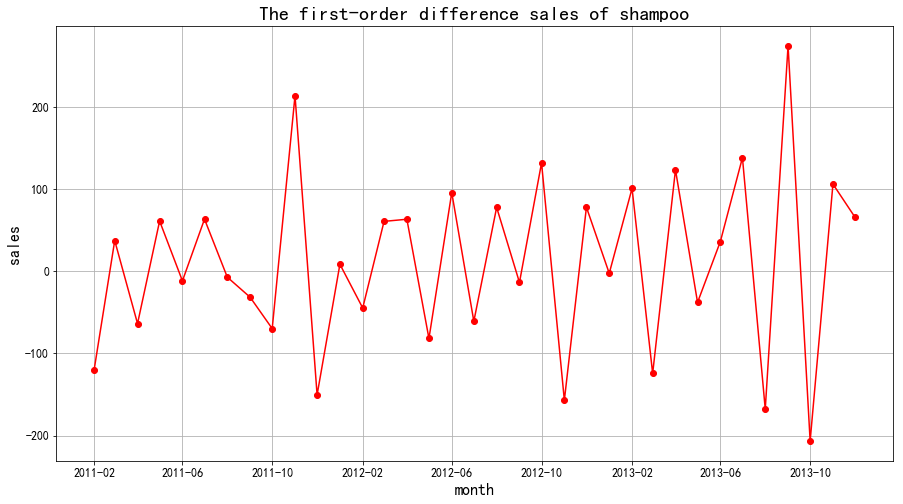

In [47]:
fig, ax = plt.subplots()
ax.plot(df_diff.index, df_diff.values, 'ro-')
ax.set_xlabel('month', fontsize=16)
ax.set_ylabel('sales', fontsize=16)
ax.set_title('The first-order difference sales of shampoo', fontsize=20)
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/洗发水销量一阶差分图.png")
plt.show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


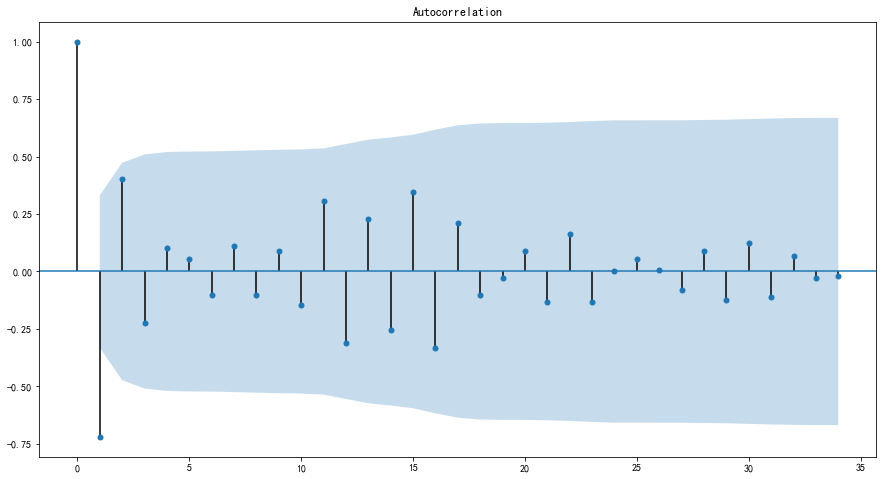

In [50]:
plot_acf(df_diff).show()

D:\Anaconda3\envs\py3_for_prac\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
D:\Anaconda3\envs\py3_for_prac\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


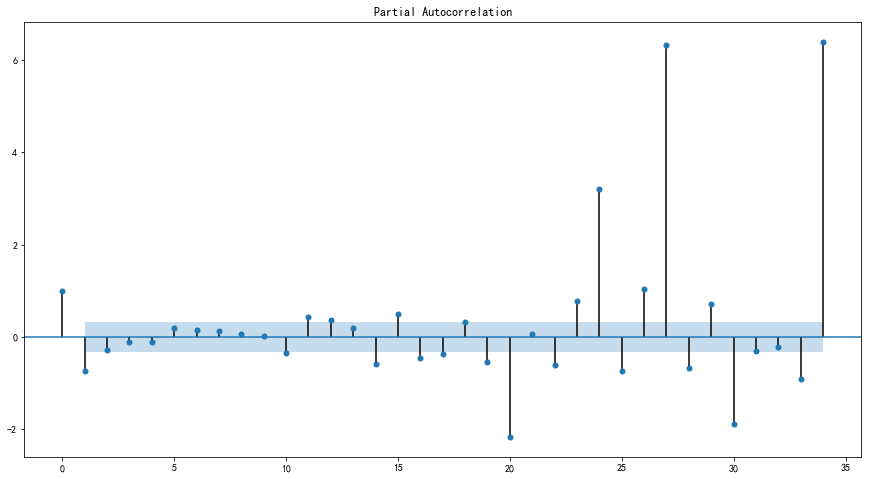

In [48]:
plot_pacf(df_diff).show()

In [51]:
# 单位根检验
adf_result = adfuller(df_diff)

output = pd.DataFrame(index=["Test Statistic Value", "p-value", "Lags Used", "Number of Observations Used", "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"], columns=['value'])
output['value']['Test Statistic Value'] = adf_result[0]
output['value']['p-value'] = adf_result[1]
output['value']['Lags Used'] = adf_result[2]
output['value']['Number of Observations Used'] = adf_result[3]
output['value']['Critical Value (1%)'] = adf_result[4]['1%']
output['value']['Critical Value (5%)'] = adf_result[4]['5%']
output['value']['Critical Value (10%)'] = adf_result[4]['10%']
print("单位根检验结果为：")
print(output)

单位根检验结果为：
                                   value
Test Statistic Value            -7.24907
p-value                      1.79986e-10
Lags Used                              1
Number of Observations Used           33
Critical Value (1%)             -3.64614
Critical Value (5%)             -2.95413
Critical Value (10%)            -2.61597


从自相关图中可以得到，$q = 3$；从偏自相关图中可以得到，$p = 3$，而差分阶数 $d = 1$，<u>**因此我们选择 ARIMA(3, 1, 3) 模型**</u>。

## 步骤3：拟合模型，测试模型效果

In [87]:
train_size = int(len(df) * 0.66)
train, test = df.values[:train_size], df.values[train_size:]

In [90]:
history = list(train)
preds = list()
for i in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[i]
    history.append(obs)
    print("predicted = %f, expected = %f" % (yhat, obs))
error = mean_squared_error(test, preds)
print("Test MSE: %.3f" % error)

predicted = 349.117712, expected = 342.300000
predicted = 306.512952, expected = 339.700000
predicted = 387.376449, expected = 440.400000
predicted = 348.154255, expected = 315.900000
predicted = 386.308818, expected = 439.300000
predicted = 356.082087, expected = 401.300000
predicted = 446.379462, expected = 437.400000
predicted = 394.737224, expected = 575.500000
predicted = 434.915402, expected = 407.600000
predicted = 507.923547, expected = 682.000000
predicted = 435.482779, expected = 475.300000
predicted = 652.743826, expected = 581.300000
predicted = 546.343519, expected = 646.900000
Test MSE: 6958.324


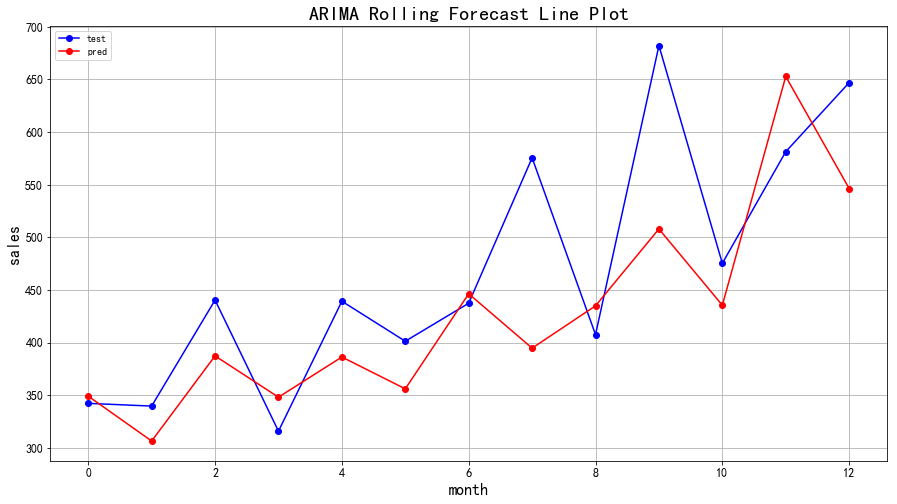

In [98]:
fig, ax = plt.subplots()
ax.plot(test, 'bo-', label='test')
ax.plot(preds, 'ro-', label='pred')
ax.set_xlabel('month', fontsize=16)
ax.set_ylabel('sales', fontsize=16)
ax.set_title('ARIMA Rolling Forecast Line Plot', fontsize=20)
ax.legend(loc='upper left')
ax.grid()

# TODO: 改变刻度字体大小不够优雅
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.savefig("../figs/ARIMA预测图.png")
plt.show()